In [1]:
from SVDModel import SVDModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import pickle
import os.path
from pathlib import Path

np.random.seed(3362)

In [2]:
PARAM = dict()
PARAM['features'] = 3
PARAM['lr'] = 0.01
PARAM['epochs'] = 501
PARAM['weight_decay'] = 0.02
PARAM['stopping'] = 0.001
PARAM['mode'] = 'svd++'

In [3]:
names = ['userId','rating','timestamp','movieId']
df_netflix = pd.read_csv('data/NetflixPrize/'+'data_1.txt', names=names, low_memory=False)
df_netflix_2 = pd.read_csv('data/NetflixPrize/'+'data_2.txt', names=names, low_memory=False)
df_netflix_3 = pd.read_csv('data/NetflixPrize/'+'data_3.txt', names=names, low_memory=False)
df_netflix_4 = pd.read_csv('data/NetflixPrize/'+'data_4.txt', names=names, low_memory=False)
df_netflix = pd.concat([df_netflix,df_netflix_2,df_netflix_3,df_netflix_4], names=names)
df_netflix['movieId'] = df_netflix['movieId'].fillna(method='ffill')
df_netflix.dropna(inplace=True)
df_netflix['rating'] = df_netflix['rating'].astype(np.int8)
df_netflix['movieId'] = df_netflix['movieId'].astype(np.int16)
df_netflix['userId'] = df_netflix['userId'].astype(np.int32)
df_netflix['timestamp'] = pd.to_datetime(df_netflix['timestamp']).view(dtype=np.int64) // 10 ** 9
df_movies = pd.read_csv('data/NetflixPrize/'+'movie_titles.csv',
                        encoding='latin-1',
                        names=['movieId','release_year','title'],
                        usecols=range(3))
NETFLIX = {
  'ratings': df_netflix[['userId','movieId','rating','timestamp']].sample(2**16),
  'movies': df_movies,
  'm_movies': df_netflix['movieId'].nunique(),
  'n_users': df_netflix['userId'].nunique(),
  'n_ratings': len(df_netflix)
}
print(NETFLIX['ratings'].shape)
print(NETFLIX['movies'].shape)

(65536, 4)
(17770, 3)


In [4]:
print('Creating SVD Model')
svd = SVDModel()
print("Created\nLoading Data")
svd.data_loader(data=NETFLIX['ratings'],
                n_items = NETFLIX['m_movies'],
                n_users= NETFLIX['n_users'])
print("Loaded Data\nSpliting Data")
svd.split(0.8,0.8)
print("Splitted Data")

Creating SVD Model
Created
Loading Data
Loaded Data
Spliting Data
User Item Matrix Shape: (54794, 7938)
User Reference length: 54794
Item Reference length: 7938
Splitted Data


In [5]:
def train_model(features, lr, epochs, weight_decay, mode):
    print("Training")
    # if os.path.isfile(f'./model_netflix/svdpp/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
    #     return
    print(f"==============================")
    print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
 
    svd.features = features
    svd.lr = lr
    svd.epochs = epochs
    svd.weight_decay = weight_decay
    svd.mode = mode
    svd.stopping = PARAM['stopping']
 

    print("Splitted Data\nTraining...")
    start = time.perf_counter()
    result = svd.training()
    print('Time used =', time.perf_counter()-start)
   
    print('Saving Model')
    Path(f"./model_netflix").mkdir(parents=True, exist_ok=True)
    Path(f"./model_netflix/svdpp").mkdir(parents=True, exist_ok=True)
    Path(f"./model_netflix/svdpp/model").mkdir(parents=True, exist_ok=True)
    Path(f"./model_netflix/svdpp/result").mkdir(parents=True, exist_ok=True)
   
   
    # with open(f'./model_netflix/svdpp/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
    #     pickle.dump(svd, out, pickle.HIGHEST_PROTOCOL)
    #     out.close()
    with open(f'./model_netflix/svdpp/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
        pickle.dump(result, out, pickle.HIGHEST_PROTOCOL)
        out.close()
    print(f"==============================")
    return svd, result

In [6]:
res_svd, result = train_model(PARAM['features'],PARAM['lr'],PARAM['epochs'],PARAM['weight_decay'],PARAM['mode'] ) 

Training
features: 3
learning rate: 0.01
Epochs: 501
weight decay: 0.02
stopping: 0.001

Splitted Data
Training...
Epoch :    1  | Train : 1.092  | Valid : 1.130  | Time : 19.27749s
Training stopped:
Epoch :    9  | Train Loss : 0.822  | Valid Loss: 1.087  | Test Loss: 1.090
Time used = 37.46388730000001
Saving Model


In [7]:
# load result
if os.path.isfile(f"./model_netflix/svdpp/result/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl"):
  # with open(f"./model_netflix/svdpp/model/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl", 'rb') as inp:
  #   svd = pickle.load(inp)
  #   inp.close()
  with open(f"./model_netflix/svdpp/result/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl", 'rb') as inp:
    result = pickle.load(inp)
    print(result[0][-1])
    print(result[1][-1])
    print(result[2])
    print(len(result[0]))
    inp.close()
    

0.8218441387917512
1.0870115404557084
1.090053962630309
9


In [8]:
from SVDModel import topKPrediction,movieRatePredictionByUserIdMovieId

### Definition of Relevant and Recommended

* Relevant: True Rating `>=` threshold
* Irrelevant: True Rating `<` threshold
* Recommended item: Predicted Rating `>=` threshold
* Not Recommended item: Predicted Rating `<` threshold

In [9]:
predictions = {
  'userId':[],
  'movieId':[],
  'actual':[],
  'prediction':[]
}
for i,(userId,movieId, actual,_) in svd.data.iterrows():
    # print(svd.test[i,j])
    prediction = movieRatePredictionByUserIdMovieId(userId=userId,movieId=movieId,model=svd)
    predictions['userId'].append(userId)
    predictions['movieId'].append(movieId)
    predictions['actual'].append(actual)
    predictions['prediction'].append(prediction)


In [10]:
df = pd.DataFrame(predictions)

In [11]:
df.head()

,userId,movieId,actual,prediction
0,2572942,16997,2,3.755091
1,856444,483,4,3.630530
2,2368112,13636,5,4.054302
3,1084697,5181,2,3.477181
4,17287,14670,2,3.835695


In [12]:
# Find a threshold
thresholds = np.arange(0,5.1,0.5)
res = {
  'precision':[],
  'recall':[],
}

from numba import njit, prange
 
@njit
def _g(df, threshold):
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0
  precision = 0
  recall = 0
  for i in prange(len(df)):
    _,_,actual,prediction = df[i]
    if actual >= threshold:
      if prediction >= threshold:
        true_positive+=1
      else:
        false_negative+=1
    else:
      if prediction >= threshold:
        false_positive+=1
      else:
        true_negative+=1
  precision = true_positive / (true_positive + false_positive) if true_positive + false_positive!=0 else 0
  recall = true_positive / (true_positive + false_negative) if true_positive + false_negative!=0 else 0
  return precision,recall

for threshold in thresholds:
  precision, recall = _g(df.to_numpy(),threshold)
  res['precision'].append(precision)
  res['recall'].append(recall)
df_res = pd.DataFrame(res, index=thresholds)
df_res


,precision,recall
0.0,1.000000,1.000000
0.5,1.000000,1.000000
1.0,1.000000,1.000000
1.5,0.953781,1.000000
2.0,0.953781,1.000000
2.5,0.853201,1.000000
3.0,0.865612,0.988175
3.5,0.699110,0.834877
4.0,0.878146,0.205500
4.5,0.828996,0.029542


the optimal threshold = `3.0`

In [13]:
from collections import defaultdict

user = defaultdict(list)
for i, (uid, _, actual, prediction) in df.iterrows():
  user[int(uid)].append((actual, prediction))


In [14]:
k = range(1,11)
stat = {
    'mAP':[],
    'average recalls':[]
}

for i in k:
    PatK_byUser = dict()
    APatK_byUser = dict()
    recalls = dict()
    for userId, user_ratings in user.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        relevant = [(actual >= 3) for (actual,_) in user_ratings]
        n_relevant = sum(relevant)
        
        
        items = [(prediction >= 3) for (_,prediction) in user_ratings[:i]]
        k_items = sum(items)
        
        relevant_in_k = [((actual >= 3) and (prediction >= 3)) for (actual, prediction) in user_ratings[:i]]
        n_relevant_in_k = sum(relevant_in_k)
        
        #P@K
        PatK_byUser[userId] = n_relevant_in_k / k_items if k_items != 0 else 1
        
        #AP@K
        APatK_byUser[userId] = 0
        
        for j,item in enumerate(relevant):
            if j >=i:
                break
            APatK_byUser[userId] += relevant_in_k[j]/(j+1)
        APatK_byUser[userId] = APatK_byUser[userId] / n_relevant_in_k if n_relevant_in_k !=0 else 1
        
        #Recall@K
        recalls[userId] = n_relevant_in_k / n_relevant if n_relevant != 0 else 1
        
    mAP = sum(APatK_byUser.values())/len(APatK_byUser)
    stat['mAP'].append(mAP)
    stat['average recalls'].append(sum(recalls.values())/len(recalls))

In [15]:
pd.DataFrame(stat,index=k)

,mAP,average recalls
1,1.000000,0.926968
2,0.970316,0.982309
3,0.967527,0.988542
4,0.967218,0.989328
5,0.967169,0.989471
6,0.967159,0.989498
7,0.967155,0.989512
8,0.967153,0.989518
9,0.967153,0.989520
10,0.967153,0.989521


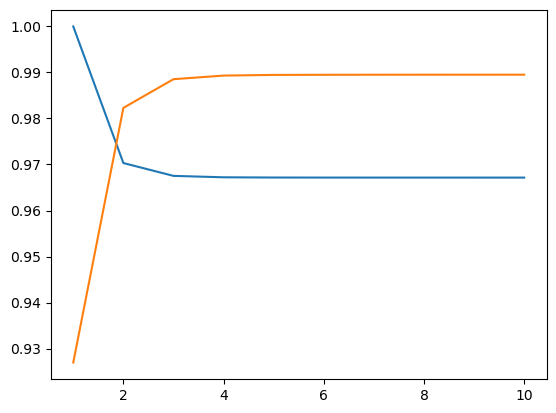

In [16]:
plt.plot(k,stat['mAP'])
plt.plot(k,stat['average recalls'])